# Fake News

## Import

In [1]:
import re
import time

import nltk
import pandas as pd
from matplotlib import pyplot as plt
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

nltk.download('punkt')  # for tokenization
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset

In [2]:
df = pd.read_csv('../american_datasets/cleaned/7.csv', index_col=0)
df.head()

title  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2                  Why the Truth Might Get You Fired   
3  15 Civilians Killed In Single US Airstrike Hav...   
4  Iranian woman jailed for fictional unpublished...   

                                                text label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...  Fake  
1  Ever get the feeling your life circles the rou...  True  
2  Why the Truth Might Get You Fired October 29, ...  Fake  
3  Videos 15 Civilians Killed In Single US Airstr...  Fake  
4  Print \nAn Iranian woman has been sentenced to...  Fake

In [3]:
df.shape

(20800, 3)

## Visualization

(array([10413.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10387.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

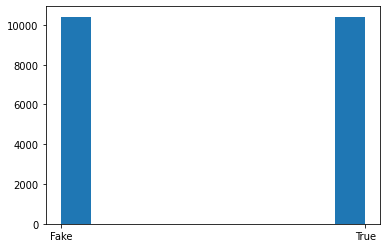

In [4]:
plt.hist(df['label'])

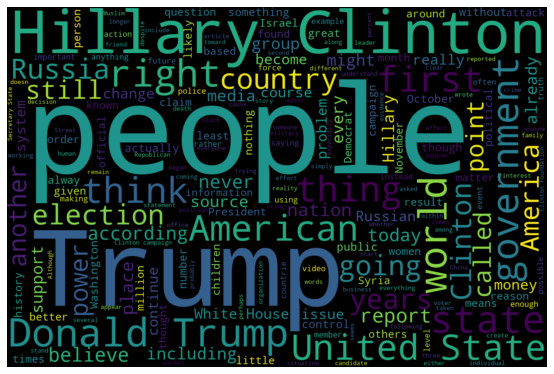

In [5]:
all_text = " ".join([str(txt) for txt in df[df['label'] == 'Fake']['text']])

wordcloud = WordCloud(min_word_length=5, width=1500, height=1000, background_color='black').generate(all_text)

fig = plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Preprocessing

### Remove junk

In [6]:
def clean(text):
    text = str(text)
    #all lowercase
    text = text.lower()

    # remove escape sequences
    text = re.sub(r'(\r\n|\n|\r|\t)', ' ', text)

    # remove urls
    text = re.sub(
        r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', ' ',
        text)

    # remove html
    text = re.sub(r'<.*?>', ' ', text)

    # remove emoj
    text = re.sub(r"["u"\U0001F600-\U0001F64F"  # emoticons
                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                  u"\U00002702-\U000027B0"
                  u"\U000024C2-\U0001F251"
                  "]+", " ", text, flags=re.UNICODE)

    # remove all not alphanumeric character
    text = re.sub("[^a-z]+", " ", text)
    return text


df['title'] = [clean(title) for title in df['title']]
df['text'] = [clean(text) for text in df['text']]
df.head()

title  \
0  house dem aide we didn t even see comey s lett...   
1  flynn hillary clinton big woman on campus brei...   
2                  why the truth might get you fired   
3   civilians killed in single us airstrike have ...   
4  iranian woman jailed for fictional unpublished...   

                                                text label  
0  house dem aide we didn t even see comey s lett...  Fake  
1  ever get the feeling your life circles the rou...  True  
2  why the truth might get you fired october the ...  Fake  
3  videos civilians killed in single us airstrike...  Fake  
4  print an iranian woman has been sentenced to s...  Fake

### Remove stop words

In [7]:
stop_words = set(stopwords.words("english"))


def remove_stop_words(text):
    res = []
    for word in text.split():
        if word not in stop_words:
            res.append(word)
    return " ".join(res)


df['title'] = [remove_stop_words(title) for title in df['title']]
df['text'] = [remove_stop_words(text) for text in df['text']]
df.head()

title  \
0  house dem aide even see comey letter jason cha...   
1   flynn hillary clinton big woman campus breitbart   
2                              truth might get fired   
3    civilians killed single us airstrike identified   
4  iranian woman jailed fictional unpublished sto...   

                                                text label  
0  house dem aide even see comey letter jason cha...  Fake  
1  ever get feeling life circles roundabout rathe...  True  
2  truth might get fired october tension intellig...  Fake  
3  videos civilians killed single us airstrike id...  Fake  
4  print iranian woman sentenced six years prison...  Fake

### Stemming

In [8]:
snowball_stemmer = SnowballStemmer(language='english')


def stemmer(text):
    res = []
    for word in text.split():
        res.append(snowball_stemmer.stem(word))
    return " ".join(res)


df['title'] = [stemmer(title) for title in df['title']]
df['text'] = [stemmer(text) for text in df['text']]
df.head()

title  \
0  hous dem aid even see comey letter jason chaff...   
1   flynn hillari clinton big woman campus breitbart   
2                               truth might get fire   
3           civilian kill singl us airstrik identifi   
4  iranian woman jail fiction unpublish stori wom...   

                                                text label  
0  hous dem aid even see comey letter jason chaff...  Fake  
1  ever get feel life circl roundabout rather hea...  True  
2  truth might get fire octob tension intellig an...  Fake  
3  video civilian kill singl us airstrik identifi...  Fake  
4  print iranian woman sentenc six year prison ir...  Fake

## ML Model

In [9]:
def print_metrics(y_test, y_pred, training_time):
    print('0. Training time:', round(training_time), 's')
    print('1. Accuracy:', round(accuracy_score(y_test, y_pred), 4))
    print('2. Precision:', round(precision_score(y_test, y_pred, average='macro'), 4))
    print('3. Recall:', round(recall_score(y_test, y_pred, average='macro'), 4))
    print('4. F1 score:', round(f1_score(y_test, y_pred, average='macro'), 4))
    print('5. Confusion Matrix\n\n', pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

In [10]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
# pre processing
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
countVectorizer = CountVectorizer(min_df=2, max_df=0.7, ngram_range=(1, 2), tokenizer=token.tokenize)
tfidfTransformer = TfidfTransformer()

classifiers = [
    RandomForestClassifier(n_jobs=8),
    LogisticRegression(n_jobs=8),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(n_jobs=8)
]

#fit and prediction
for classifier in classifiers:
    start_time = time.time()
    
    print('---------------------------------')
    print(str(classifier))
    pipe = Pipeline(
        [
            ('vect', countVectorizer),
            ('tfidf', tfidfTransformer),
            ('classifier', classifier)
        ]
    )

    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    training_time = time.time() - start_time 
    print_metrics(y_test, y_pred, training_time)

---------------------------------
RandomForestClassifier(n_jobs=8)


0. Training time: 22 s
1. Accuracy: 0.9069
2. Precision: 0.9073
3. Recall: 0.9068
4. F1 score: 0.9069
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake       2767   337
True        244  2892
---------------------------------
LogisticRegression(n_jobs=8)


0. Training time: 16 s
1. Accuracy: 0.9474
2. Precision: 0.9474
3. Recall: 0.9474
4. F1 score: 0.9474
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake       2947   157
True        171  2965
---------------------------------
DecisionTreeClassifier()


0. Training time: 49 s
1. Accuracy: 0.8888
2. Precision: 0.8888
3. Recall: 0.8888
4. F1 score: 0.8888
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake       2751   353
True        341  2795
---------------------------------
AdaBoostClassifier()


0. Training time: 49 s
1. Accuracy: 0.9329
2. Precision: 0.9329
3. Recall: 0.9329
4. F1 score: 0.9329
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake       2919   185
True        234  2902
---------------------------------
KNeighborsClassifier(n_jobs=8)


0. Training time: 15 s
1. Accuracy: 0.5103
2. Precision: 0.7519
3. Recall: 0.5128
4. F1 score: 0.3599
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake       3104     0
True       3056    80
